
<div class="alert alert-info">

**This is a fixed-text formatted version of a Jupyter notebook**

- Try online [![Binder](https://static.mybinder.org/badge.svg)](https://mybinder.org/v2/gh/gammapy/gammapy-webpage/v0.17?urlpath=lab/tree/analysis_3d.ipynb)
- You can contribute with your own notebooks in this
[GitHub repository](https://github.com/gammapy/gammapy/tree/master/tutorials).
- **Source files:**
[analysis_3d.ipynb](../_static/notebooks/analysis_3d.ipynb) |
[analysis_3d.py](../_static/notebooks/analysis_3d.py)
</div>


# 3D analysis

This tutorial does a 3D map based analsis on the galactic center, using simulated observations from the CTA-1DC. We will use the high level interface for the data reduction, and then do a detailed modelling. This will be done in two different ways:

- stacking all the maps together and fitting the stacked maps
- handling all the observations separately and doing a joint fitting on all the maps

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import astropy.units as u
from pathlib import Path
from regions import CircleSkyRegion
from gammapy.analysis import Analysis, AnalysisConfig
from gammapy.modeling.models import (
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
    PointSpatialModel,
)
from gammapy.modeling import Fit
from gammapy.maps import Map

## Analysis configuration

In this section we select observations and define the analysis geometries, irrespective of  joint/stacked analysis. For configuration of the analysis, we will programatically build a config file from scratch.

In [2]:
config = AnalysisConfig()
# The config file is now empty, with only a few defaults specified.
print(config)

AnalysisConfig

    general:
        log: {level: info, filename: null, filemode: null, format: null, datefmt: null}
        outdir: .
    observations:
        datastore: $GAMMAPY_DATA/hess-dl3-dr1
        obs_ids: []
        obs_file: null
        obs_cone: {frame: null, lon: null, lat: null, radius: null}
        obs_time: {start: null, stop: null}
    datasets:
        type: 1d
        stack: true
        geom:
            wcs:
                skydir: {frame: null, lon: null, lat: null}
                binsize: 0.02 deg
                fov: {width: 5.0 deg, height: 5.0 deg}
                binsize_irf: 0.2 deg
            selection: {offset_max: 2.5 deg}
            axes:
                energy: {min: 0.1 TeV, max: 10.0 TeV, nbins: 30}
                energy_true: {min: 0.1 TeV, max: 10.0 TeV, nbins: 30}
        map_selection: [counts, exposure, background, psf, edisp]
        background:
            method: null
            exclusion: null
            parameters: {}
        safe_m

In [3]:
# Selecting the observations
config.observations.datastore = "$GAMMAPY_DATA/cta-1dc/index/gps/"
config.observations.obs_ids = [110380, 111140, 111159]

In [4]:
# Defining a reference geometry for the reduced datasets

config.datasets.type = "3d"  # Analysis type is 3D

config.datasets.geom.wcs.skydir = {
    "lon": "0 deg",
    "lat": "0 deg",
    "frame": "galactic",
}  # The WCS geometry - centered on the galactic center
config.datasets.geom.wcs.fov = {"width": "10 deg", "height": "8 deg"}
config.datasets.geom.wcs.binsize = "0.02 deg"

# The FoV radius to use for cutouts
config.datasets.geom.selection.offset_max = 3.5 * u.deg
config.datasets.safe_mask.methods = ["aeff-default", "offset-max"]

# We now fix the energy axis for the counts map - (the reconstructed energy binning)
config.datasets.geom.axes.energy.min = "0.1 TeV"
config.datasets.geom.axes.energy.max = "10 TeV"
config.datasets.geom.axes.energy.nbins = 10

# We now fix the energy axis for the IRF maps (exposure, etc) - (the true enery binning)
config.datasets.geom.axes.energy_true.min = "0.08 TeV"
config.datasets.geom.axes.energy_true.max = "12 TeV"
config.datasets.geom.axes.energy_true.nbins = 14

In [5]:
print(config)

AnalysisConfig

    general:
        log: {level: info, filename: null, filemode: null, format: null, datefmt: null}
        outdir: .
    observations:
        datastore: $GAMMAPY_DATA/cta-1dc/index/gps
        obs_ids: [110380, 111140, 111159]
        obs_file: null
        obs_cone: {frame: null, lon: null, lat: null, radius: null}
        obs_time: {start: null, stop: null}
    datasets:
        type: 3d
        stack: true
        geom:
            wcs:
                skydir: {frame: galactic, lon: 0.0 deg, lat: 0.0 deg}
                binsize: 0.02 deg
                fov: {width: 10.0 deg, height: 8.0 deg}
                binsize_irf: 0.2 deg
            selection: {offset_max: 3.5 deg}
            axes:
                energy: {min: 0.1 TeV, max: 10.0 TeV, nbins: 10}
                energy_true: {min: 0.08 TeV, max: 12.0 TeV, nbins: 14}
        map_selection: [counts, exposure, background, psf, edisp]
        background:
            method: null
            exclusion: null
  

## Configuration for stacked and joint analysis

This is done just by specfiying the flag on `config.datasets.stack`. Since the internal machinery will work differently for the two cases, we will write it as two config files and save it to disc in YAML format for future reference. 

In [6]:
config_stack = config.copy(deep=True)
config_stack.datasets.stack = True

config_joint = config.copy(deep=True)
config_joint.datasets.stack = False

In [7]:
# To prevent unnecessary cluttering, we write it in a separate folder.
path = Path("analysis_3d")
path.mkdir(exist_ok=True)
config_joint.write(path=path / "config_joint.yaml", overwrite=True)
config_stack.write(path=path / "config_stack.yaml", overwrite=True)

## Stacked analysis

### Data reduction

We first show the steps for the stacked analysis and then repeat the same for the joint analysis later


In [8]:
# Reading yaml file:
config_stacked = AnalysisConfig.read(path=path / "config_stack.yaml")

In [9]:
analysis_stacked = Analysis(config_stacked)

Setting logging config: {'level': 'INFO', 'filename': None, 'filemode': None, 'format': None, 'datefmt': None}


In [10]:
%%time
# select observations:
analysis_stacked.get_observations()

# run data reduction
analysis_stacked.get_datasets()

Fetching observations.
Number of selected observations: 3
Creating geometry.
Creating datasets.
No background maker set for 3d analysis. Check configuration.
Processing observation 110380
No thresholds defined for obs Observation

	obs id            : 110380 
 	tstart            : 59235.50
	tstop             : 59235.52
	duration          : 1800.00 s
	pointing (icrs)   : 267.7 deg, -29.6 deg

	deadtime fraction : 2.0%

Processing observation 111140
No thresholds defined for obs Observation

	obs id            : 111140 
 	tstart            : 59275.50
	tstop             : 59275.52
	duration          : 1800.00 s
	pointing (icrs)   : 264.2 deg, -29.5 deg

	deadtime fraction : 2.0%

Processing observation 111159
No thresholds defined for obs Observation

	obs id            : 111159 
 	tstart            : 59276.50
	tstop             : 59276.52
	duration          : 1800.00 s
	pointing (icrs)   : 266.0 deg, -27.0 deg

	deadtime fraction : 2.0%



CPU times: user 7.66 s, sys: 2.27 s, total: 9.93 s
Wall time: 10.3 s


We have one final dataset, which you can print and explore

In [11]:
dataset_stacked = analysis_stacked.datasets["stacked"]
print(dataset_stacked)

MapDataset
----------

  Name                            : stacked 

  Total counts                    : 121241 
  Total predicted counts          : 108043.52
  Total background counts         : 108043.52

  Exposure min                    : 6.28e+07 m2 s
  Exposure max                    : 1.90e+10 m2 s

  Number of total bins            : 2000000 
  Number of fit bins              : 1411180 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 625436.39

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: BackgroundModel
  
    Name                      : stacked-bkg
    Datasets names            : ['stacked']
    Parameters:
      norm                    :   1.000              
      tilt         (frozen)   :   0.000              
      reference    (frozen)   :   1.000  TeV         
  
  


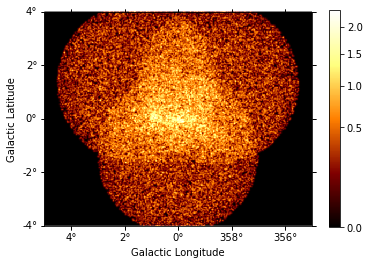

In [12]:
# To plot a smooth counts map
dataset_stacked.counts.smooth(0.02 * u.deg).plot_interactive(add_cbar=True)

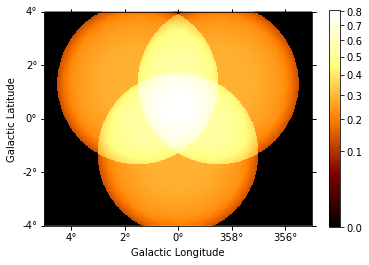

In [13]:
# And the background map
dataset_stacked.background_model.map.plot_interactive(add_cbar=True)

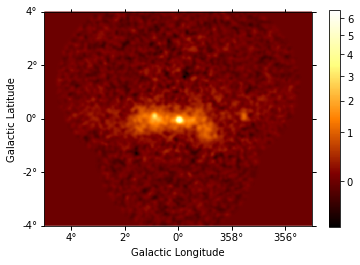

In [14]:
# You can also get an excess image with a few lines of code:
counts = dataset_stacked.counts.sum_over_axes()
background = dataset_stacked.background_model.map.sum_over_axes()
excess = counts - background
excess.smooth("0.06 deg").plot(stretch="sqrt", add_cbar=True);

### Modeling and fitting

Now comes the interesting part of the analysis - choosing appropriate models for our source and fitting them.

We choose a point source model with an exponential cutoff power-law spectrum.

To select a certain energy range for the fit we can create a fit mask:

In [15]:
coords = dataset_stacked.counts.geom.get_coord()
mask_energy = coords["energy"] > 0.3 * u.TeV
dataset_stacked.mask_fit = Map.from_geom(
    geom=dataset_stacked.counts.geom, data=mask_energy
)

In [16]:
spatial_model = PointSpatialModel(
    lon_0="-0.05 deg", lat_0="-0.05 deg", frame="galactic"
)
spectral_model = ExpCutoffPowerLawSpectralModel(
    index=2.3,
    amplitude=2.8e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1.0 * u.TeV,
    lambda_=0.02 / u.TeV,
)

model = SkyModel(
    spatial_model=spatial_model,
    spectral_model=spectral_model,
    name="gc-source",
)

dataset_stacked.models.append(model)
dataset_stacked.background_model.norm.value = 1.3

In [17]:
%%time
fit = Fit([dataset_stacked])
result = fit.run(optimize_opts={"print_level": 1})

------------------------------------------------------------------
| FCN = 2.802E+05               |     Ncalls=177 (177 total)     |
| EDM = 9.39E-05 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
CPU times: user 9.19 s, sys: 2.41 s, total: 11.6 s
Wall time: 11.7 s


In [18]:
result.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str14,float64,float64,bool,float64
norm,1.248e+00,,0.000e+00,nan,False,6.448e-03
tilt,0.000e+00,,nan,nan,True,0.000e+00
reference,1.000e+00,TeV,nan,nan,True,0.000e+00
index,2.240e+00,,nan,nan,False,1.146e-01
amplitude,2.909e-12,cm-2 s-1 TeV-1,nan,nan,False,3.341e-13
reference,1.000e+00,TeV,nan,nan,True,0.000e+00
lambda_,5.311e-02,TeV-1,nan,nan,False,6.112e-02
alpha,1.000e+00,,nan,nan,True,0.000e+00
lon_0,-5.166e-02,deg,nan,nan,False,2.338e-03


### Check model fit

We check the model fit by computing and plotting a residual image:

(<matplotlib.axes._subplots.WCSAxesSubplot at 0x116012c18>, None)

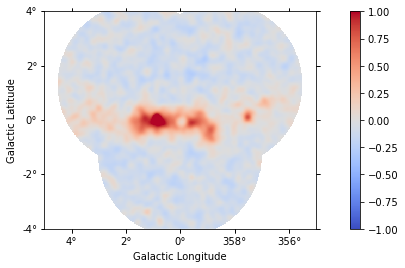

In [19]:
dataset_stacked.plot_residuals(method="diff/sqrt(model)", vmin=-1, vmax=1)

We can also plot the best fit spectrum. For that need to extract the covariance of the spectral parameters.

## Joint analysis

In this section, we perform a joint analysis of the same data. Of course, joint fitting is considerably heavier than stacked one, and should always be handled with care. For brevity, we only show the analysis for a point source fitting without re-adding a diffuse component again. 

### Data reduction

In [20]:
%%time

# Read the yaml file from disk
config_joint = AnalysisConfig.read(path=path / "config_joint.yaml")
analysis_joint = Analysis(config_joint)

# select observations:
analysis_joint.get_observations()

# run data reduction
analysis_joint.get_datasets()

Setting logging config: {'level': 'INFO', 'filename': None, 'filemode': None, 'format': None, 'datefmt': None}
Fetching observations.
Number of selected observations: 3
Creating geometry.
Creating datasets.
No background maker set for 3d analysis. Check configuration.
Processing observation 110380
No thresholds defined for obs Observation

	obs id            : 110380 
 	tstart            : 59235.50
	tstop             : 59235.52
	duration          : 1800.00 s
	pointing (icrs)   : 267.7 deg, -29.6 deg

	deadtime fraction : 2.0%

Processing observation 111140
No thresholds defined for obs Observation

	obs id            : 111140 
 	tstart            : 59275.50
	tstop             : 59275.52
	duration          : 1800.00 s
	pointing (icrs)   : 264.2 deg, -29.5 deg

	deadtime fraction : 2.0%

Processing observation 111159
No thresholds defined for obs Observation

	obs id            : 111159 
 	tstart            : 59276.50
	tstop             : 59276.52
	duration          : 1800.00 s
	pointing

CPU times: user 6.94 s, sys: 1.97 s, total: 8.91 s
Wall time: 9.01 s


In [21]:
# You can see there are 3 datasets now
print(analysis_joint.datasets)

Datasets
--------
idx=0, id='0x1180b8c18', name='-fbzIRNK'
idx=1, id='0x115ccf550', name='tk5xvVAM'
idx=2, id='0x115fc0080', name='1cpoqF7u'



In [22]:
# You can access each one by name or by index, eg:
print(analysis_joint.datasets[0])

MapDataset
----------

  Name                            : -fbzIRNK 

  Total counts                    : 47736 
  Total predicted counts          : 42655.01
  Total background counts         : 42655.01

  Exposure min                    : 6.28e+07 m2 s
  Exposure max                    : 6.68e+09 m2 s

  Number of total bins            : 1085000 
  Number of fit bins              : 693940 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 250423.04

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: BackgroundModel
  
    Name                      : -fbzIRNK-bkg
    Datasets names            : ['-fbzIRNK']
    Parameters:
      norm                    :   1.000              
      tilt         (frozen)   :   0.000              
      reference    (frozen)   :   1.000  TeV         
  
  


In [23]:
# Add the model on each of the datasets
model_joint = model.copy(name="source-joint")
for dataset in analysis_joint.datasets:
    dataset.models.append(model_joint)
    dataset.background_model.norm.value = 1.1

In [24]:
%%time
fit_joint = Fit(analysis_joint.datasets)
result_joint = fit_joint.run()

CPU times: user 27 s, sys: 5.37 s, total: 32.4 s
Wall time: 32.7 s


In [25]:
print(result)

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 177
	total stat : 280219.84



In [26]:
fit_joint.datasets.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str14,float64,float64,bool,float64
norm,1.117e+00,,0.000e+00,nan,False,5.577e-03
tilt,0.000e+00,,nan,nan,True,0.000e+00
reference,1.000e+00,TeV,nan,nan,True,0.000e+00
index,2.290e+00,,nan,nan,False,7.647e-02
amplitude,2.885e-12,cm-2 s-1 TeV-1,nan,nan,False,3.116e-13
reference,1.000e+00,TeV,nan,nan,True,0.000e+00
lambda_,3.500e-02,TeV-1,nan,nan,False,5.131e-02
alpha,1.000e+00,,nan,nan,True,0.000e+00
lon_0,-5.244e-02,deg,nan,nan,False,2.225e-03


The information which parameter belongs to which dataset is not listed explicitly in the table (yet), but the order of parameters is conserved. You can always access the underlying object tree as well to get specific parameter values:

In [27]:
for dataset in analysis_joint.datasets:
    print(dataset.background_model.norm.value)

1.1172921144380115
1.1185249877971581
1.1111161210830067


### Residuals

Since we have multiple datasets, we can either look at a stacked residual map, or the residuals for each dataset. Each `gammapy.cube.MapDataset` object is equipped with a method called `gammapy.cube.MapDataset.plot_residuals()`, which displays the spatial and spectral residuals (computed as *counts-model*) for the dataset. Optionally, these can be normalized as *(counts-model)/model* or *(counts-model)/sqrt(model)*, by passing the parameter `norm='model` or `norm=sqrt_model`.

In [28]:
# To see the spectral residuals, we have to define a region for the spectral extraction
region = CircleSkyRegion(spatial_model.position, radius=0.15 * u.deg)

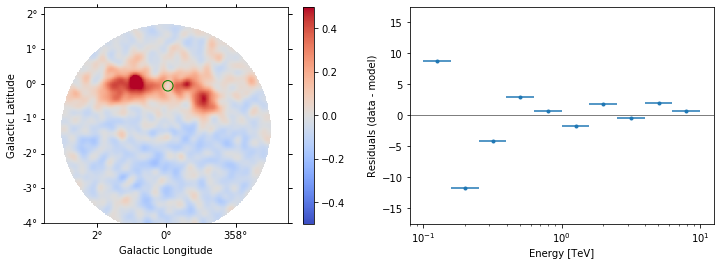

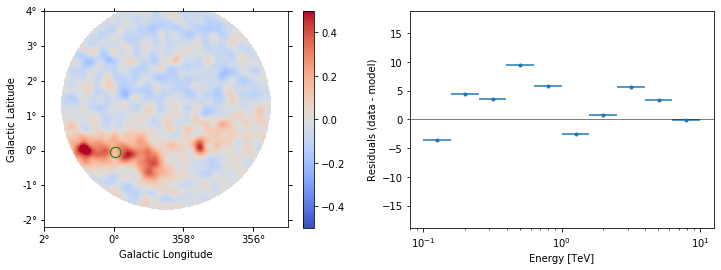

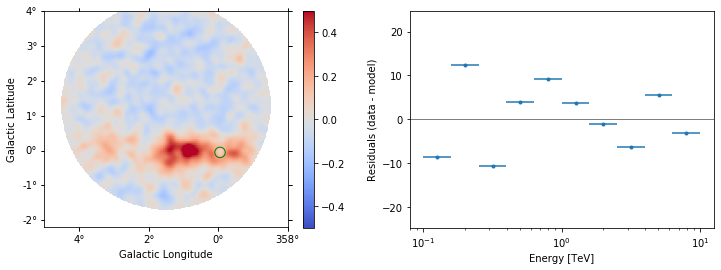

In [29]:
for dataset in analysis_joint.datasets:
    ax_image, ax_spec = dataset.plot_residuals(
        region=region, vmin=-0.5, vmax=0.5, method="diff"
    )

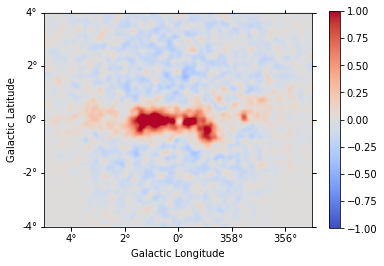

In [30]:
# We need to stack on the full geometry, so we use to geom from the stacked counts map.
residuals_stacked = Map.from_geom(analysis_stacked.datasets[0].counts.geom)

for dataset in analysis_joint.datasets:
    residuals = dataset.residuals()
    residuals_stacked.stack(residuals)

residuals_stacked.sum_over_axes().smooth("0.08 deg").plot(
    vmin=-1, vmax=1, cmap="coolwarm", add_cbar=True, stretch="linear"
);

Finally let us compare the spectral results from the stacked and joint fit:

In [31]:
def plot_spectrum(model, result, label, color):
    spec = model.spectral_model
    energy_range = [0.3, 10] * u.TeV
    spec.plot(
        energy_range=energy_range, energy_power=2, label=label, color=color
    )
    spec.plot_error(energy_range=energy_range, energy_power=2, color=color)

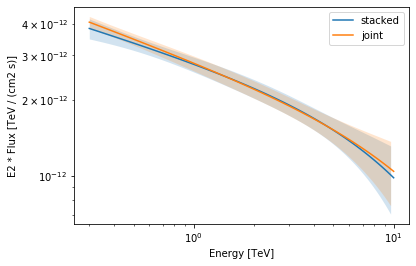

In [32]:
plot_spectrum(model, result, label="stacked", color="tab:blue")
plot_spectrum(model_joint, result_joint, label="joint", color="tab:orange")
plt.legend()

## Summary

Note that this notebook aims to show you the procedure of a 3D analysis using just a few observations. Results get much better for a more complete analysis considering the GPS dataset from the CTA First Data Challenge (DC-1) and also the CTA model for the Galactic diffuse emission, as shown in the next image:

![](images/DC1_3d.png)

The complete tutorial notebook of this analysis is available to be downloaded in [GAMMAPY-EXTRA](https://github.com/gammapy/gammapy-extra) repository at https://github.com/gammapy/gammapy-extra/blob/master/analyses/cta_1dc_gc_3d.ipynb).

## Exercises

* Analyse the second source in the field of view: G0.9+0.1 and add it to the combined model.
* Perform modeling in more details - Add diffuse component, get flux points.